In [1]:
import numpy as np, matplotlib.pyplot as plt
from collections import OrderedDict as od
from scipy.special import comb as C
from scipy.stats import linregress
from statistics import median
from scipy.optimize import fminbound
import json
import itertools
from tqdm.notebook import tqdm
#from multiprocess import Pool

In [2]:
def get_entropy_from_culling_factor_v2(c):
    S = od()
    sn = 0
    for E in c:
        S[E] = np.log(c[E])
        S[E] += sn
        sn += np.log(1 - c[E])
    return S

def get_entropy_from_culling_factor_with_heat_v2(c):
    S = od()
    sn = 0
    for E in c:
        S[E] = np.log(c[E])
        S[E] += sn
        sn += np.log(1 - c[E])
    return S

def stitch_S(heat, cool):
    #not infinite values
    niv = sorted( list({E for E, S in heat["S"].items() if not np.isinf(S)} &
                       {E for E, S in cool["S"].items() if not np.isinf(S)}) )
    #chosen not infinite values
    cniv = niv[len(niv) // 3 : 2 * len(niv) // 3]
    #print(cniv)
    shift = 0
    count = 0
    for E in cniv:
        shift += heat["S"][E] - cool["S"][E]
        count += 1
    shift /= count

    result = od()
    for E in cool["S"]:
        if E < median(cniv):
            result[E] = cool["S"][E]
    for E in heat["S"]:
        if E >= median(cniv):
            result[E] = heat["S"][E] - shift

    result = dict(sorted(result.items(), key=lambda item: item[0]))
    return {"S": result, "L": heat["L"]}

def calc_hc(st, T):

    E = mp.mpf(0)
    E_sq = mp.mpf(0)
    E_qr = mp.mpf(0)
    Z = mp.mpf(0)
    for fe, fS in st['S'].items():
        e = mp.mpf(fe)
        S = mp.mpf(fS)
        w = mp.exp(S - e / T)
        Z += w
        E += w * e
        E_sq += w * e * e
        E_qr += w * e * e * e * e
    avgE = E / Z;
    avgE_sq = E_sq / Z;
    avgE_qr = E_qr / Z;
    # T, C, average E, BinderCumulant
    return T, float( (avgE_sq - avgE * avgE) / (T * T) ), float( avgE ), float(1 - (avgE_qr / (3 * avgE_sq * avgE_sq)))

In [5]:
def read_files_v2(parameters, prefix='', name=''):
    q=parameters["q"];
    L=parameters["L"];
    R=parameters["R"];
    D=parameters["D"];
    nSteps=parameters["nSteps"];
    seed=parameters["seed"];
    heat=parameters["heat"];
    N = L * L;
    if name == '':
        name = ".{}/2DBlume{}_q{}_D{}_N{}_R{}_nSteps{}_run{}X.txt".format(prefix,"Heating" * heat, q, "{0:07.6f}".format(D), N, R, nSteps, seed)
    print(name)
    culling_factor = od()
    print(N, R, nSteps, heat)
    with open(name) as f:
        for line in f:
            E, c = map(float, line.split())
            culling_factor[E] = c
    parameters["culling_factor"] = culling_factor
    if not heat:
        parameters["S"] = get_entropy_from_culling_factor_v2(culling_factor)
    else:
        parameters["S"] = get_entropy_from_culling_factor_with_heat_v2(culling_factor)
    
    return parameters

def read_tuple_files(tpl, prefix='', name=''):
        cool = read_files_v2(tpl[0], prefix, name)
        return {
            "cool": cool,
        }

In [7]:
q = 3
D = 1.95
L = 32
R = 131072

cool = [{
    "q": q,
    "L": L,
    "D": D,
    "R" : R,
    "nSteps" : 10,
    "seed" : 0,
    "heat": False
}]

parameters = read_tuple_files(cool, prefix='/datasets')

coolAR = [{
    "q": q,
    "L": L,
    "D": 39,#D,
    "R" : R,
    "nSteps" : 10,
    "seed" : 0,
    "heat": False
}]

parametersAR = read_tuple_files(coolAR, prefix='/AR_datasets/datasets_22092023', name='2DBlume_q3_D39_N1024_R131072_nSteps10_run0X.txt')

./datasets/2DBlume_q3_D1.950000_N1024_R131072_nSteps10_run0X.txt
1024 131072 10 False


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


2DBlume_q3_D39_N1024_R131072_nSteps10_run0X.txt
1024 131072 10 False


FileNotFoundError: [Errno 2] No such file or directory: '2DBlume_q3_D39_N1024_R131072_nSteps10_run0X.txt'

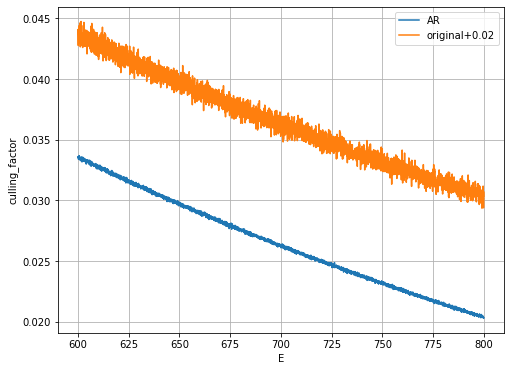

In [12]:
plt.figure(figsize=(8, 6))
a = 600
b = 800
plt.plot([E for E, S in parametersAR['cool']['culling_factor'].items() if E >= a and E <= b],
         [S for E, S in parametersAR['cool']['culling_factor'].items() if E >= a and E <= b],
        label='AR')
plt.plot([E for E, S in parameters['cool']['culling_factor'].items() if E >= a and E <= b],
         [S + 0.01 for E, S in parameters['cool']['culling_factor'].items() if E >= a and E <= b],
        label='original+0.02')
plt.grid()
plt.ylabel('culling_factor')
plt.xlabel('E')
plt.legend()
plt.show()

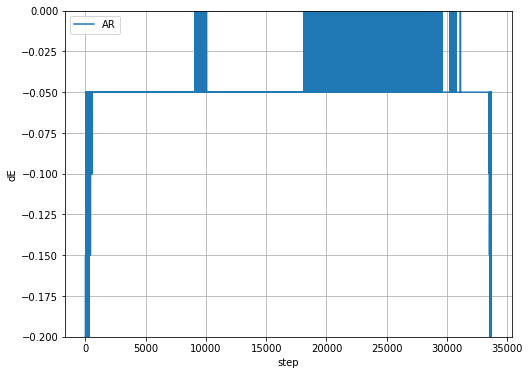

In [22]:
plt.figure(figsize=(8, 6))
plt.plot(np.diff([E for E, S in parametersAR['cool']['culling_factor'].items()]),label='AR')
plt.grid()
plt.ylabel('dE')
plt.ylim([-0.2, 0])
plt.xlabel('step')
plt.legend()
plt.show()

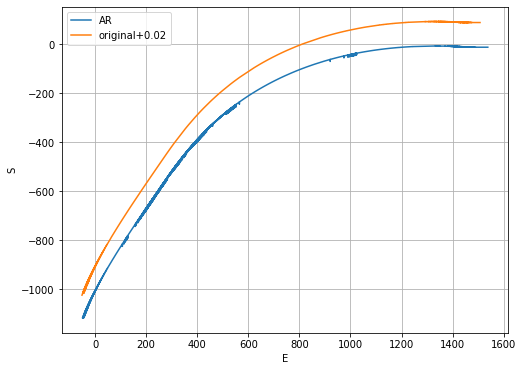

In [9]:
plt.figure(figsize=(8, 6))
plt.plot([E for E, S in parametersAR['cool']['S'].items()], [S for E, S in parametersAR['cool']['S'].items()],
        label='AR')
plt.plot([E for E, S in parameters['cool']['S'].items()], [S + 100 for E, S in parameters['cool']['S'].items()],
        label='original+0.02')
plt.grid()
plt.ylabel('S')
plt.xlabel('E')
plt.legend()
plt.show()

In [18]:
import mpmath as mp
mp.mp.dps = 50
mp.mp.pretty = True
print(mp.mp)

Mpmath settings:
  mp.prec = 169               [default: 53]
  mp.dps = 50                 [default: 15]
  mp.trap_complex = False     [default: False]


In [19]:
beta = np.log(1 + np.sqrt(q))
beta, 1 / beta

(1.4260624389053682, 0.7012315679302166)

In [20]:
d = {}
d100 = {}
md = {}

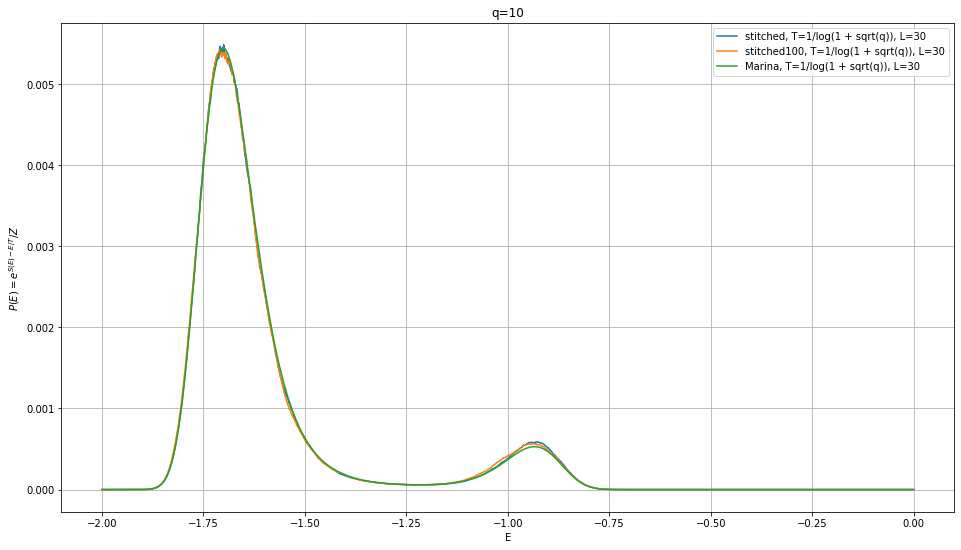

In [21]:
plt.figure(figsize=(16, 9))
i = 0
#e_o, e_d = -1.44721 - 0.0264594, -1.44721 + 0.0264594
#delta = 0.00058
delta = 0
if delta:
    s = ["1/log(1 + sqrt(q)) + {}".format(delta)]
else:
    s = ["1/log(1 + sqrt(q))"]
for j, T in enumerate([1 / beta + delta]):
    st = parameters[i]["stitched"]
    st100 = parameters100[i]["stitched"]
    L = st['L']
    if (L not in d):
        d = {L: {}}
        d100= {L: {}}
        md = {L: {}}
    if (T in d[L]):
        y = d[L][T]
        y100 = d[L][T]
        my = md[L][T]
    else:
        y = np.array([mp.exp(mp.mpf(S) - mp.mpf(E) / T) for E, S in st["S"].items()])
        y100 = np.array([mp.exp(mp.mpf(S) - mp.mpf(E) / T) for E, S in st100["S"].items()])
        my = np.array([mp.exp(mp.mpf(S) - mp.mpf(E) / T) for E, S in parameters_marina.items()])
        Z = sum(y)
        Z100 = sum(y100)
        mZ = sum(my)
        y /= Z
        y100 /= Z100
        my /= mZ
        d[L][T] = y
        d100[L][T] = y100
        md[L][T] = my

    x = np.array([E / (L * L) for E in st["S"]])
    x100 = np.array([E / (L * L) for E in st100["S"]])
    mx = np.array([E / (L * L) for E in parameters_marina])
    plt.plot(x, y, '-', label="stitched, T={}, L={}".format(s[j], L))
    plt.plot(x100, y100, '-', label="stitched100, T={}, L={}".format(s[j], L))
    plt.plot(mx, my, '-', label="Marina, T={}, L={}".format(s[j], L))

#plt.axvline(x=e_o, label='e_o', c='g')
#plt.axvline(x=e_d, label='e_d', c='b')

plt.ylabel('$P(E) = e^{S(E) - E / T} / Z$')
plt.xlabel("E")
#plt.xlim([0, 0.01])
#plt.ylim([0, 0.01])
#plt.yscale('log')
plt.title("q={}".format(q))
plt.legend()
plt.grid()
#if delta:
#    plt.savefig("./images/marina_P(E)_Potts_q{}_L{}_equal.png".format(q, st["L"]))
#else:
#    plt.savefig("./images/marina_P(E)_Potts_q{}_L{}.png".format(q, st["L"]))

#with open("./tmp/P(E)_Potts_q{}_L{}.txt".format(q, st["L"]), 'w') as fp:
#    for E, P in zip(x, y):
#        fp.write('{}\t{}\n'.format(E, P))

NameError: name 'e_o' is not defined

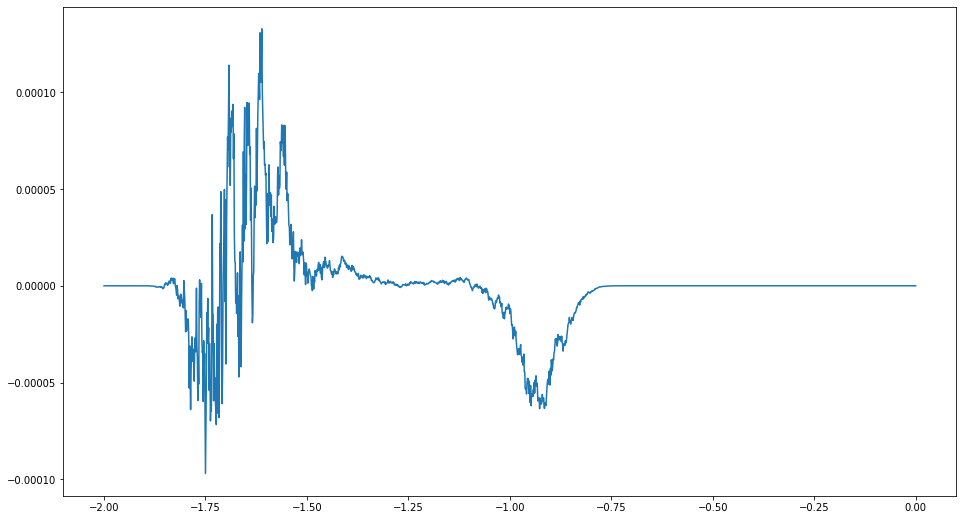

In [22]:
plt.figure(figsize=(16, 9))

plt.plot(mx, my - y, '-', label="diff, T={}, L={}".format(s[j], L))

plt.axvline(x=e_o, label='e_o', c='g')
plt.axvline(x=e_d, label='e_d', c='b')

plt.ylabel('$P(E) = e^{S(E) - E / T} / Z$')
plt.xlabel("E")
#plt.xlim([0, 0.01])
#plt.ylim([0, 0.01])
#plt.yscale('log')
plt.title("q={}".format(q))
plt.legend()
plt.grid()
if delta:
    plt.savefig("./images/marina_diff_P(E)_Potts_q{}_L{}_equal.png".format(q, st["L"]))
else:
    plt.savefig("./images/marina_diff_P(E)_Potts_q{}_L{}.png".format(q, st["L"]))
